function ConnectButton(){
  console.log("Connect pushed"); 
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

# **1. Pre-requisites**

## **1.1. Libraries**

In [1]:
from google.colab import drive

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
# from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import time
import math

import cv2
print(f"OpenCV Version: {cv2.__version__}")
print(f'TensorFlow Version : {tf.__version__}')

import matplotlib.pyplot as plt

import pickle

from sklearn.metrics import label_ranking_average_precision_score

OpenCV Version: 4.1.2
TensorFlow Version : 2.7.0


## **1.2. Mount Google Drive folder**

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **1.3. User defined functions**

El siguiente feature_map ayuda a descomponer cada una de los samples del TREC (imagenes) en informacion importante de cada uno de ellos:

In [3]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)
}

La siguiente función permite preprocesar una determinada imagen y devolverla junto con su label (enfermedad toracica).

In [4]:
def image_decoder(data, resize_shape = (224,224)):
    example = tf.io.parse_single_example(data, feature_map)
    image = example['image']
    image = tf.io.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, resize_shape[0], resize_shape[1])
    image.set_shape(resize_shape+(3,))
    image = tf.cast(image, tf.float32) / 255.0
    
    print([label for label in sorted(list(example.keys())) if label!='image' and label!='image_id' and label != "No Finding"])
    labels = [tf.cast(example[x], tf.float32) for x in sorted(list(example.keys())) if x!='image_id' and x != "No Finding" and x!="" and x!='image']
    
    #id = tf.cast(example['image_id'], tf.string)
    #return image, labels, id

    return image, labels

La siguiente funcion es capaz de crear un `TensorFlow Dataset` desde un archivo TF Record.
La salida va a ser un ``prefetchDataset`` lo cual permite realizar el preprocesamiento de los datos a la vez que entrenamiento de TF para no bloquear el disco disponible con demasiado I/O.
Vemos como el numero de datos spobre los que se realiza el preset esta puesto como AUTOTUNE. Esto lo que hará es cambiar el numero de datos que se sacan del buffer dinamicamente en base al entrenamiento dependiendo de cuantos datos por batch necesite este.
Info importante sobre esto: https://www.tensorflow.org/guide/data_performance#prefetching

In [5]:
def tfr_decoder(path, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size=None, prefetch=True):

  data_list = [os.path.join(path,x) for x in os.listdir(path)]
  data_list.sort()
  #data_list = data_list[:30]
  train_end = int(len(data_list)*train_percent) 
  val_end = train_end + int(len(data_list)*val_percent)
  train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]
  
  trainds = tf.data.TFRecordDataset(train_data)
  trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  trainds = trainds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
  #print("Length of train dataset: " + str(sum(1 for _ in trainds)))
  
  valds = tf.data.TFRecordDataset(val_data)
  valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  valds = valds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
  #print("Length of val dataset: " + str(sum(1 for _ in valds)))

  testds = tf.data.TFRecordDataset(test_data)
  testds = testds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  testds = testds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
  #print("Length of val dataset: " + str(sum(1 for _ in testds)))

  if shuffle:
    trainds = trainds.shuffle(1024)

  if batch_size != None:
    trainds = trainds.batch(batch_size)
    valds = valds.batch(batch_size)
    testds = testds.batch(batch_size)

  if prefetch:
    trainds = trainds.prefetch(tf.data.experimental.AUTOTUNE)
    valds = valds.prefetch(tf.data.experimental.AUTOTUNE)
    testds = testds.prefetch(tf.data.experimental.AUTOTUNE)
    
  return trainds, valds, testds

Función para extraer las labels de los tensorflow.datasets:

In [6]:
def generate_df_from_prefetch_ds(tf_dataset, len_dataset):
  batch_size = tf_dataset._input_dataset._batch_size.numpy()
  batch_numbers = math.ceil(len_dataset/batch_size)
  matrix = []
  for iteration, sample in enumerate(tf_dataset.take(batch_numbers)):
    if iteration==(int(len_dataset/batch_size)):
      batch_size = len_dataset%batch_size
    for i in range(batch_size):
      matrix.append(list(sample[1][i].numpy()))
  df_test_real = pd.DataFrame(matrix, columns = class_names_list)#.apply(lambda x : x.astype("int32"))
  return df_test_real

Funciones de evaluación de modelos:

In [7]:
def get_LRAP(y_pred_df, y_df):
  return label_ranking_average_precision_score(y_true = y_df.values.tolist(), y_score = y_pred_df.values.tolist())

def get_MAP_at_k(y_pred_df, y_df, k=3, mean_over_samples=True):
  #Sort vectors based on probabilities of the prediction.
  y_p = []
  y_r = []
  for i in range(len(y_pred_df)):
    y_pred = y_pred_df.iloc[i].values.tolist()
    y_real = y_df.iloc[i].values.tolist()
    indexes_order = np.argsort(y_pred)[::-1]
    y_pred_sorted = [y_pred[k] for k in indexes_order]
    y_real_sorted = [y_real[k] for k in indexes_order]
    y_p.append(y_pred_sorted)
    y_r.append(y_real_sorted)
  #Slice vector to top_k probabilities.
  y_p_k = np.array(y_p)[:,:k]
  y_r_k = np.array(y_r)[:,:k]
  denominator = np.array(list(map(lambda x: min (x,k), np.sum(y_r,axis=1))))
  result = np.sum(y_r_k,axis=1) / denominator
  if mean_over_samples:
    result = np.mean(result)
  return result

## **1.4. Load variables**

In [34]:
tfrec_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/data/"
csv_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/"
csv_columns = ["path_name","No Finding","Atelectasis","Consolidation","Infiltration","Pneumothorax","Edema","Emphysema",
               "Fibrosis","Effusion","Pneumonia","Pleural_Thickening","Cardiomegaly","Nodule","Mass","Hernia"]
class_names_list = sorted(csv_columns[2:])
print(csv_columns)
print(class_names_list)

model_name = "InceptionV3_06b"
filesrepo_path = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/repofiles/"

['path_name', 'No Finding', 'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [31]:
y_real_df_filename = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/Pruebas-Jordi/var_y_real_df.v"

with open(y_real_df_filename, "rb") as f:
    y_real_df = pickle.load(f)

print("y_real_df:")
print(y_real_df)

y_real_df:
      Atelectasis  Cardiomegaly  ...  Pneumonia  Pneumothorax
0             0.0           0.0  ...        0.0           0.0
1             1.0           0.0  ...        0.0           0.0
2             0.0           0.0  ...        0.0           0.0
3             0.0           0.0  ...        0.0           0.0
4             1.0           0.0  ...        0.0           0.0
...           ...           ...  ...        ...           ...
5424          0.0           0.0  ...        0.0           0.0
5425          0.0           0.0  ...        0.0           0.0
5426          0.0           0.0  ...        0.0           0.0
5427          0.0           0.0  ...        0.0           0.0
5428          0.0           1.0  ...        0.0           0.0

[5429 rows x 14 columns]


# **2. Read CSV & lightweight exploration**

In [ ]:
data_csv = pd.read_csv(csv_folder+"preprocessed_data.csv", skiprows=[0], header=None, names=csv_columns)
data_len = len(data_csv)
print(data_len)
data_csv.head()

112120


,path_name,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [ ]:
cols_to_review = csv_columns[1:].copy()
# cols_to_review = class_names_list.copy()

In [ ]:
for i, col in enumerate(cols_to_review):
  conteo = data_csv[col].sum()
  print('{:>2} {:<18}: {:>6} ({:>5.2f}%)'.format(i, col, conteo, conteo/data_len*100))

conteo = 0
for col in cols_to_review:
  conteo += data_csv[col].sum()
print()
print('Número total de True : {}'.format(conteo))

 0 No Finding        :  60361 (53.84%)
 1 Atelectasis       :  11559 (10.31%)
 2 Consolidation     :   4667 ( 4.16%)
 3 Infiltration      :  19894 (17.74%)
 4 Pneumothorax      :   5302 ( 4.73%)
 5 Edema             :   2303 ( 2.05%)
 6 Emphysema         :   2516 ( 2.24%)
 7 Fibrosis          :   1686 ( 1.50%)
 8 Effusion          :  13317 (11.88%)
 9 Pneumonia         :   1431 ( 1.28%)
10 Pleural_Thickening:   3385 ( 3.02%)
11 Cardiomegaly      :   2776 ( 2.48%)
12 Nodule            :   6331 ( 5.65%)
13 Mass              :   5782 ( 5.16%)
14 Hernia            :    227 ( 0.20%)

Número total de True : 141537


In [ ]:
diseases_dict = {}
for i in range(data_len):
  row = list(data_csv.iloc[i])[1:]
  # print(row)
  title = '+'.join([x for i, x in enumerate(cols_to_review) if row[i]])
  # print(i, title)
  if title not in diseases_dict:
    # print(title)
    diseases_dict[title] = 0
  diseases_dict[title] += 1

In [ ]:
print(diseases_dict)
print('Número de combinaciones: {}'.format(len(diseases_dict)))
recuento = 0
for disease in list(diseases_dict.keys()):
  recuento += diseases_dict[disease]
print('Suma de valores de diccionario: {}'.format(conteo))

{'Cardiomegaly': 1093, 'Emphysema+Cardiomegaly': 19, 'Effusion+Cardiomegaly': 484, 'No Finding': 60361, 'Hernia': 110, 'Infiltration+Hernia': 15, 'Nodule+Mass': 396, 'Infiltration': 9547, 'Infiltration+Effusion': 1604, 'Nodule': 2705, 'Emphysema': 892, 'Effusion': 3955, 'Atelectasis': 4215, 'Effusion+Mass': 402, 'Pneumothorax+Emphysema': 337, 'Pleural_Thickening': 1126, 'Infiltration+Pneumothorax+Emphysema+Effusion': 12, 'Infiltration+Pneumothorax+Emphysema+Pleural_Thickening': 6, 'Pneumothorax+Effusion+Pneumonia': 4, 'Pneumothorax': 2194, 'Infiltration+Pneumothorax+Effusion': 88, 'Infiltration+Mass': 420, 'Infiltration+Pneumothorax+Mass': 15, 'Mass': 2139, 'Infiltration+Cardiomegaly+Nodule+Mass': 2, 'Emphysema+Effusion+Cardiomegaly+Mass': 3, 'Atelectasis+Pneumothorax+Emphysema+Cardiomegaly+Mass': 1, 'Emphysema+Mass': 66, 'Pneumothorax+Emphysema+Mass': 30, 'Atelectasis+Pneumothorax': 241, 'Pneumothorax+Emphysema+Cardiomegaly': 2, 'Pleural_Thickening+Mass': 132, 'Pleural_Thickening+Card

In [ ]:
len(diseases_dict)

801

In [ ]:
sorted_tuples = sorted(diseases_dict.items(), key=lambda item: item[1], reverse=True)
recuento_parcial = 0
recuento_total = 0
number_to_print = 25

for i in range(len(diseases_dict)):
  recuento_total += sorted_tuples[i][1]
  if i < number_to_print:
    print('{:>2} {}'.format(i, sorted_tuples[i]))
    recuento_parcial += sorted_tuples[i][1]
print()
print('Número de enfermades entre las {} primeras: {}\nNúmero total de enfermedades: {}'.format(number_to_print, recuento_parcial, recuento_total))
# diseases_dict_sorted = {k: v for k, v in sorted_tuples}
# diseases_dict_sorted

 0 ('No Finding', 60361)
 1 ('Infiltration', 9547)
 2 ('Atelectasis', 4215)
 3 ('Effusion', 3955)
 4 ('Nodule', 2705)
 5 ('Pneumothorax', 2194)
 6 ('Mass', 2139)
 7 ('Infiltration+Effusion', 1604)
 8 ('Atelectasis+Infiltration', 1350)
 9 ('Consolidation', 1310)
10 ('Atelectasis+Effusion', 1167)
11 ('Pleural_Thickening', 1126)
12 ('Cardiomegaly', 1093)
13 ('Emphysema', 892)
14 ('Infiltration+Nodule', 829)
15 ('Atelectasis+Infiltration+Effusion', 739)
16 ('Fibrosis', 727)
17 ('Edema', 628)
18 ('Effusion+Cardiomegaly', 484)
19 ('Consolidation+Infiltration', 441)
20 ('Infiltration+Mass', 420)
21 ('Pneumothorax+Effusion', 403)
22 ('Effusion+Mass', 402)
23 ('Atelectasis+Consolidation', 398)
24 ('Nodule+Mass', 396)

Número de enfermades entre las 25 primeras: 99525
Número total de enfermedades: 112120


# **3. Load TF datasets**

Creamos los datasets de **Train**, **Validation** y **Test**:


In [9]:
train_ds, val_ds, test_ds = tfr_decoder(tfrec_folder, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size=128, prefetch=True)
print(type(train_ds))
print(train_ds)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 14)), types: (tf.float32, tf.float32)>


In [11]:
train_size = 41278
val_size = 5052
test_size = 5429

# **4. Show datasets images**

### With next(iter(df))

In [ ]:
def show_batch(X, Y):
  plt.figure(figsize=(15, 15))
  for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(X[n])

    result = [x for i, x in enumerate(class_names_list) if Y[n][i]]
    title = "+".join(result)

    plt.title(title)
    plt.axis("off")

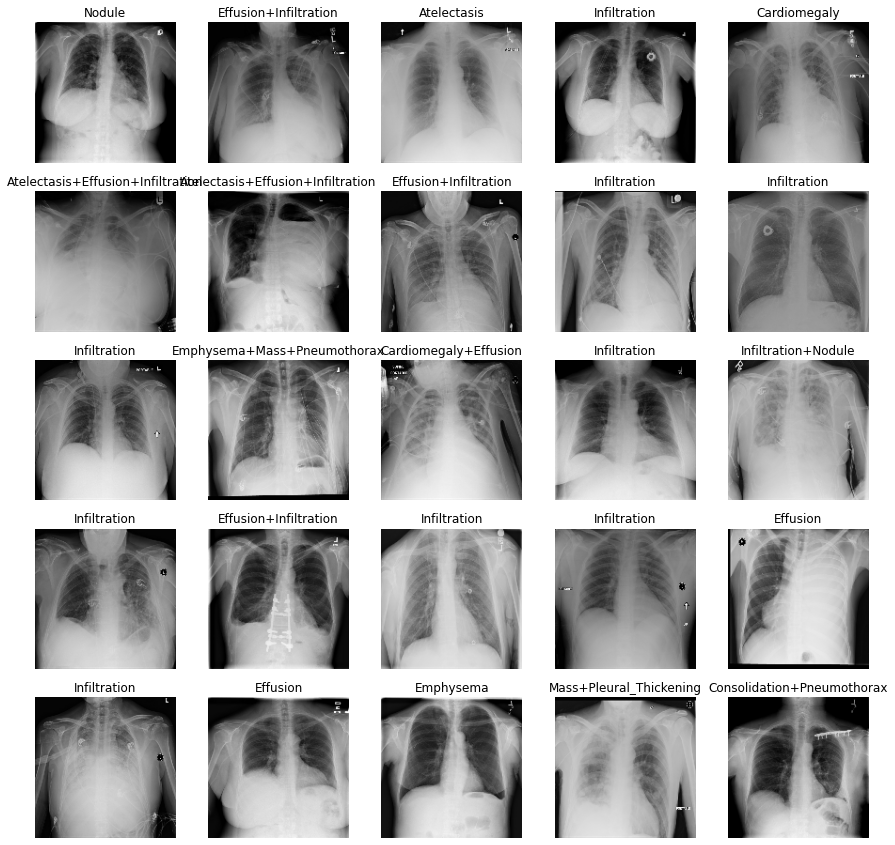

In [ ]:
image_viz, label_viz = next(iter(train_ds))

show_batch(image_viz.numpy(), label_viz.numpy())

## With take()

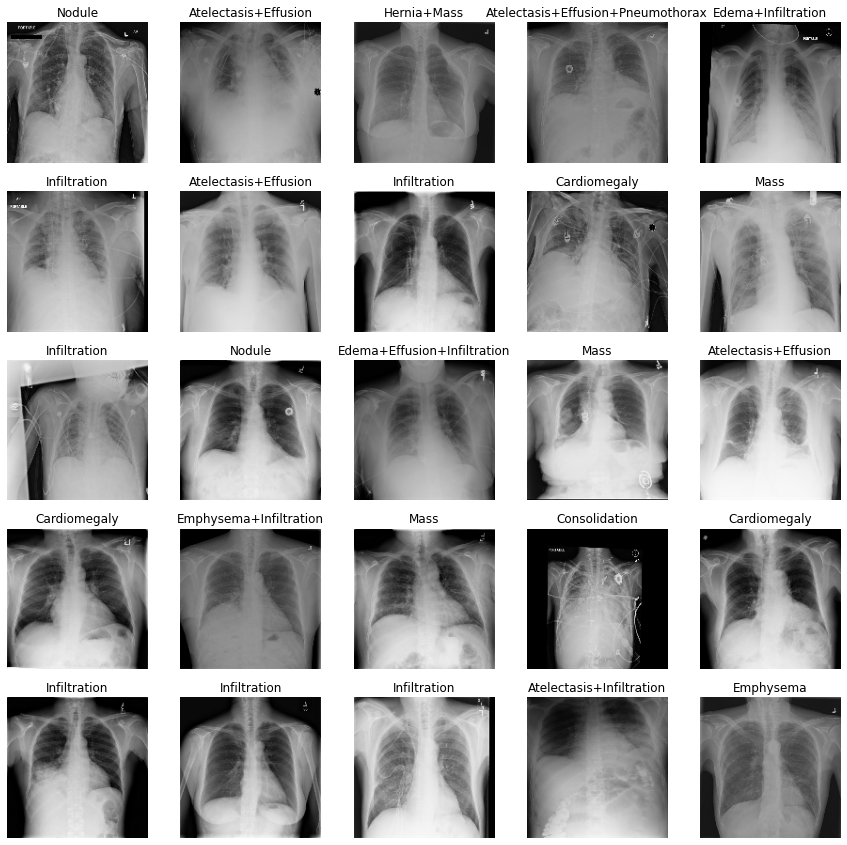

In [ ]:
for sample in train_ds.take(1):
  # print(sample)
  image_viz = sample[0]
  label_viz = sample[1]
  show_batch(image_viz.numpy(), label_viz.numpy())

# **5. Modeling**

## **5.1. Base model**

In [10]:
image_size = (224,224,3)
print(image_size)
out_shape = len(class_names_list)
print(out_shape)

(224, 224, 3)
14


In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [12]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=image_size)

In [13]:
base_model.trainable = True
# base_model.summary()
# plot_model(base_model, show_shapes=True)

In [14]:
layers_conv2d_trainable = ["conv2d_26", "conv2d_71", "conv2d_75", "conv2d_80", "conv2d_77", "conv2d_81", "conv2d_78", "conv2d_79", "conv2d_82", "conv2d_83", "conv2d_76", "conv2d_89", "conv2d_86", "conv2d_90", "conv2d_87", "conv2d_88", "conv2d_91", "conv2d_92", "conv2d_85", "conv2d_93"]
# layers_conv2d_trainable = ["conv2d_71", "conv2d_75", "conv2d_80", "conv2d_77", "conv2d_81", "conv2d_78", "conv2d_79", "conv2d_82", "conv2d_83", "conv2d_76", "conv2d_89", "conv2d_86", "conv2d_90", "conv2d_87", "conv2d_88", "conv2d_91", "conv2d_92", "conv2d_85", "conv2d_93"]
layers_batch_trainable = [layer.name for layer in base_model.layers if layer.name.startswith("batch")]
layers_trainable = layers_conv2d_trainable+layers_batch_trainable
print(layers_trainable)
print()

for layer in base_model.layers:
  if layer.name not in layers_trainable:
    layer.trainable=False
    # print("-----{:<25}: {}".format(layer.name, layer.trainable))
  else:
    # print("{:<30}: {}".format(layer.name, layer.trainable))
    print("{}, ".format(layer.name, layer.trainable), end="")

['conv2d_26', 'conv2d_71', 'conv2d_75', 'conv2d_80', 'conv2d_77', 'conv2d_81', 'conv2d_78', 'conv2d_79', 'conv2d_82', 'conv2d_83', 'conv2d_76', 'conv2d_89', 'conv2d_86', 'conv2d_90', 'conv2d_87', 'conv2d_88', 'conv2d_91', 'conv2d_92', 'conv2d_85', 'conv2d_93', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_8', 'batch_normalization_6', 'batch_normalization_9', 'batch_normalization_5', 'batch_normalization_7', 'batch_normalization_10', 'batch_normalization_11', 'batch_normalization_15', 'batch_normalization_13', 'batch_normalization_16', 'batch_normalization_12', 'batch_normalization_14', 'batch_normalization_17', 'batch_normalization_18', 'batch_normalization_22', 'batch_normalization_20', 'batch_normalization_23', 'batch_normalization_19', 'batch_normalization_21', 'batch_normalization_24', 'batch_normalization_25', 'batch_normalization_27', 'batch_normalization_28', 'batch_normalization_26

In [15]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

## **5.2. Fine-tuning**

In [16]:
inputs = keras.Input(shape=image_size)

x = base_model(inputs, training=False)

x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.3)(x)

outputs = layers.Dense(out_shape, 'sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()
# plot_model(model, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

## **5.3. Fitting**

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filesrepo_path+"Jordi-"+model_name+"-checkpoint.h5",#_{epoch:02d}.h5",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=4, restore_best_weights=True)

In [20]:
start = time.time()
history = model.fit(train_ds,
                    epochs=40,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint_callback, es])
end = time.time()

Epoch 1/40
323/323 [==============================] - 264s 741ms/step - loss: 0.3204 - auc: 0.5045 - val_loss: 0.3082 - val_auc: 0.5437
Epoch 2/40
323/323 [==============================] - 251s 767ms/step - loss: 0.3056 - auc: 0.5187 - val_loss: 0.2985 - val_auc: 0.5783
Epoch 3/40
323/323 [==============================] - 250s 762ms/step - loss: 0.3008 - auc: 0.5575 - val_loss: 0.2957 - val_auc: 0.5998
Epoch 4/40
323/323 [==============================] - 248s 759ms/step - loss: 0.2969 - auc: 0.5903 - val_loss: 0.2941 - val_auc: 0.6149
Epoch 5/40
323/323 [==============================] - 247s 756ms/step - loss: 0.2938 - auc: 0.6133 - val_loss: 0.2902 - val_auc: 0.6372
Epoch 6/40
323/323 [==============================] - 246s 752ms/step - loss: 0.2908 - auc: 0.6298 - val_loss: 0.2898 - val_auc: 0.6361
Epoch 7/40
323/323 [==============================] - 247s 755ms/step - loss: 0.2874 - auc: 0.6484 - val_loss: 0.2842 - val_auc: 0.6609
Epoch 8/40
323/323 [============================

In [21]:
train_time = end-start
print('Fitting time: {}m{:02d}s'.format(int(train_time/60),int(train_time%int(train_time/60))))

Fitting time: 103m05s


## **5.4. Dump & Load**

### **5.4.1. Dumps**

In [35]:
model.save(filesrepo_path+"Jordi-"+model_name+"-model.h5")

In [36]:
with open(filesrepo_path+"Jordi-"+model_name+"-history.pickle", "wb") as f:
  pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://ed5ee60a-e6d5-4c2c-833f-8c7160d2f54e/assets


### **5.4.2. Loads**

In [34]:
model = keras.models.load_model(filesrepo_path+"Jordi-"+model_name+"-model.h5")

In [35]:
model.load_weights(filesrepo_path+"Jordi-"+model_name+"-checkpoint.h5")

In [ ]:
history = pickle.load(open(filesrepo_path+"Jordi-"+model_name+"-history.pickle", "rb"))

In [ ]:
history

# **6. Evaluation**

### **6.1. Loss: Training vs Validation datasets**

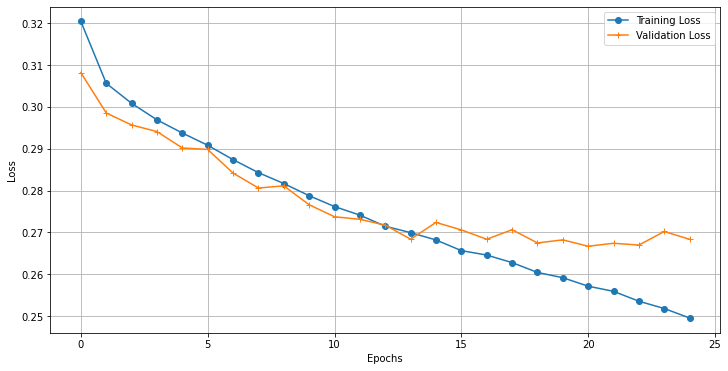

In [22]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss", marker='o')
plt.plot( history.history["val_loss"], label = "Validation Loss", marker='+')
plt.grid(True)
plt.legend()
plt.show()

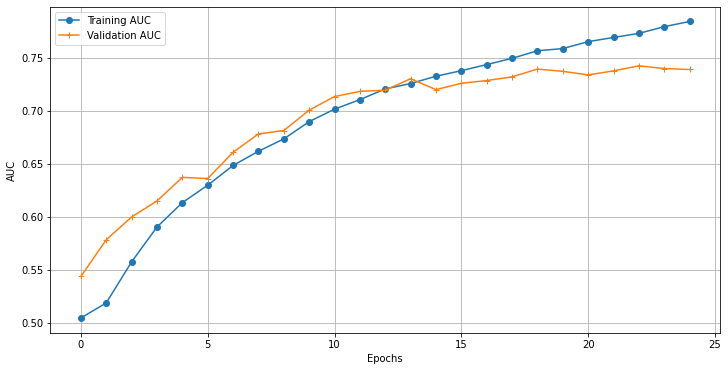

In [23]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.plot( history.history["auc"], label = "Training AUC" , marker='o')
plt.plot( history.history["val_auc"], label = "Validation AUC", marker='+')
plt.grid(True)
plt.legend()
plt.show()

Una vez entrenado podemos evaluar como se comporta con datos del dataset de validación:

### **6.2. Loss: Test dataset**

In [24]:
test_loss = model.evaluate(test_ds)[0]

43/43 [==============================] - 19s 432ms/step - loss: 0.2663 - auc: 0.7349


In [25]:
print("test_loss: {:.5f}".format(test_loss))

test_loss: 0.26628


Podemos plotear la funcion de perdida asi como la AUC en el dataset de validación 

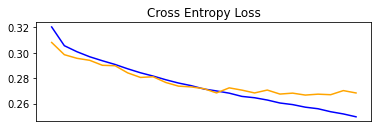

In [26]:
#Plot loss
ax = plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
ax.axes.xaxis.set_visible(False)

### **6.3. MAP@K & LRAP**

In [27]:
predictions = model.predict(test_ds)

In [28]:
print(len(predictions))
y_pred_df = pd.DataFrame(predictions, columns = class_names_list)
y_pred_df

5429


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.065410,0.002663,0.031399,0.003327,0.032714,0.032386,0.093180,0.003328,0.377294,0.182562,0.276599,0.090306,0.015868,0.056103
1,0.778643,0.022740,0.015105,0.002739,0.064011,0.026517,0.017795,0.008850,0.215750,0.042427,0.044510,0.015435,0.010925,0.015665
2,0.293002,0.055263,0.083904,0.012553,0.424934,0.026599,0.059640,0.011035,0.254307,0.149616,0.111214,0.122796,0.026312,0.051089
3,0.115651,0.014724,0.025366,0.002942,0.035057,0.021263,0.033309,0.004291,0.544356,0.085618,0.149410,0.051809,0.018714,0.031634
4,0.342249,0.059248,0.153907,0.026767,0.613681,0.018090,0.022152,0.003284,0.299232,0.113232,0.064418,0.085646,0.027510,0.044133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5424,0.150039,0.005306,0.048495,0.009599,0.084820,0.411092,0.012209,0.001401,0.284256,0.105757,0.088751,0.051482,0.009488,0.516184
5425,0.148746,0.020900,0.034124,0.005659,0.051385,0.028923,0.050734,0.007296,0.445185,0.106475,0.168767,0.063552,0.021572,0.037014
5426,0.172517,0.001162,0.019967,0.000676,0.194512,0.309888,0.012883,0.000859,0.123903,0.095216,0.073612,0.101076,0.003157,0.656974
5427,0.095880,0.005727,0.030890,0.003793,0.040337,0.025620,0.062590,0.003868,0.397251,0.162862,0.248799,0.079666,0.017059,0.030710


In [ ]:
# y_real_df = generate_df_from_prefetch_ds(test_ds, len(predictions))

In [ ]:
# with open(y_real_df_filename, "wb") as f:
#   pickle.dump(y_real_df, f)

In [32]:
y_real_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5424,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We are now going to define two metrics on the test dataset
- **MAP@5** (Mean Average Precision at 3): Esto simboliza que de las primeras 5 probabilidades mas altas cdevueltas por nuestro dataframe (o numero de labels target 1 si es menor), cuantas son las targets deseadas.
![MAP](https://drive.google.com/uc?id=1f36UqUgoEQso6a4GZ2ooMse4A7Hs5gnq)
- **LRAP** (Label Ranking average precision) measures the average precision of the predictive model but instead using precision-recall. It measures the label rankings of each sample. Its value is always greater than 0. The best value of this metric is 1. This metric is related to average precision but used label ranking instead of precision and recall
LRAP basically asks the question that for each of the given samples what percents of the higher-ranked labels were true labels.
Given a binary indicator matrix of ground-truth labels.
EXPLICACION:
https://stackoverflow.com/questions/55881642/how-to-interpret-label-ranking-average-precision-score/56857102
https://www.geeksforgeeks.org/multilabel-ranking-metrics-label-ranking-average-precision-ml/
![MAP](https://drive.google.com/uc?id=1SewLi0d_EupTF_awijPjtZE1Kk2f91qf)

In [33]:
k=3
print("Overall LRAP : {:.5f}".format(get_LRAP(y_pred_df, y_real_df)))
print("Overall MAP@{}: {:.5f}".format(k, get_MAP_at_k(y_pred_df, y_real_df, k=k)))

Overall LRAP : 0.62035
Overall MAP@3: 0.67403


# **7. Product output**


In [37]:
def tfr_decoder2(path, shuffle=True, train_percent=0.8, val_percent=0.1, mode=1, batch_size=None, prefetch=True):
  data_list = [os.path.join(path,x) for x in os.listdir(path)]
  data_list.sort()
  #data_list = data_list[:30]
  train_end = int(len(data_list)*train_percent) 
  val_end = train_end + int(len(data_list)*val_percent)
  train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]
  
  trainds = tf.data.TFRecordDataset(train_data)
  trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if mode == 1:
    trainds = trainds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
  elif mode == 2:
    trainds = trainds.filter(lambda img, labels: tf.math.reduce_sum(labels) == 0)
  #print("Length of train dataset: " + str(sum(1 for _ in trainds)))
  
  valds = tf.data.TFRecordDataset(val_data)
  valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if mode == 1:
    valds = valds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
  elif mode == 2:
    valds = valds.filter(lambda img, labels: tf.math.reduce_sum(labels) == 0)
  #print("Length of val dataset: " + str(sum(1 for _ in valds)))

  testds = tf.data.TFRecordDataset(test_data)
  testds = testds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if mode == 1:
    testds = testds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
  elif mode == 2:
    testds = testds.filter(lambda img, labels: tf.math.reduce_sum(labels) == 0)
  #print("Length of val dataset: " + str(sum(1 for _ in testds)))

  if shuffle:
    trainds = trainds.shuffle(1024)

  if batch_size != None:
    trainds = trainds.batch(batch_size)
    valds = valds.batch(batch_size)
    testds = testds.batch(batch_size)

  if prefetch:
    trainds = trainds.prefetch(tf.data.experimental.AUTOTUNE)
    valds = valds.prefetch(tf.data.experimental.AUTOTUNE)
    testds = testds.prefetch(tf.data.experimental.AUTOTUNE)
    
  return trainds, valds, testds

In [38]:
def get_images_labels_from_tfrec(path, n_of_samples=9, mode=1, shuffle=True, shuffle_buffer_size=437, seed=123):
  _,_,test_ds = tfr_decoder2(path, shuffle=shuffle, train_percent=0.8, val_percent=0.1, mode=mode, batch_size=None, prefetch=False)
  #Shuffle the dataset
  images = []
  y_true = []
  if shuffle:
    test_ds = test_ds.shuffle(shuffle_buffer_size, seed=seed)
  for sample in test_ds.take(n_of_samples):
    images.append(sample[0])
    y_true.append(sample[1])
  images_arr = np.array(images)
  y_true_arr = np.array(y_true)
  print(images_arr.shape, y_true_arr.shape)
  return images_arr, y_true_arr

In [39]:
def simulate_project_output(model, images, class_names, k_prob=3, y_real=None, figure_size=(25,30)):
  y_pred = model.predict(images)
  n_samples = images.shape[0]

  #Getting metrics
  y_pred_df = pd.DataFrame(y_pred, columns = class_names)
  y_real_df = pd.DataFrame(y_real, columns = class_names)
  lrap = get_LRAP(y_pred_df, y_real_df)
  ap_k = get_MAP_at_k(y_pred_df, y_real_df, k=k_prob, mean_over_samples=False)
  mean_ap_k = np.mean(ap_k)

  plt.figure(figsize = figure_size)

  for n in range(n_samples):
    ax = plt.subplot(3, 3, n + 1)
    ax = plt.imshow(images[n])

    lrap_n = label_ranking_average_precision_score([y_real[n]], [y_pred[n]])
    y_ref_string = [x for i, x in enumerate(class_names) if y_real[n][i]]
    
    indexes_order = np.argsort(y_pred[n])[::-1]
    predictions_string = [str(ix+1) + ". " + class_names[index] + ": " + str(round(y_pred[n][index],5)) for ix, index in enumerate(indexes_order) if ix < k_prob]

    title = " + ".join(y_ref_string)
    title = "Real disease(s): " + title + "\n\n"
    title = title + "Predicted disease(s):\n"
    title = title + "\n".join(predictions_string)
    title = title + "\n\nLRAP: {:.5f}\nMAP@{}: {:.5f}".format(lrap_n, k_prob, ap_k[n])
    plt.title(title)
    plt.axis("off")

## **7.1 Images with disease**

In [40]:
images_sample, y_sample = get_images_labels_from_tfrec(tfrec_folder, mode=1, shuffle=False, seed=123)
print(images_sample.shape, y_sample.shape)
print(y_sample)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
(9, 224, 224, 3) (9, 14)
(9, 224, 224, 3) (9, 14)
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 

3


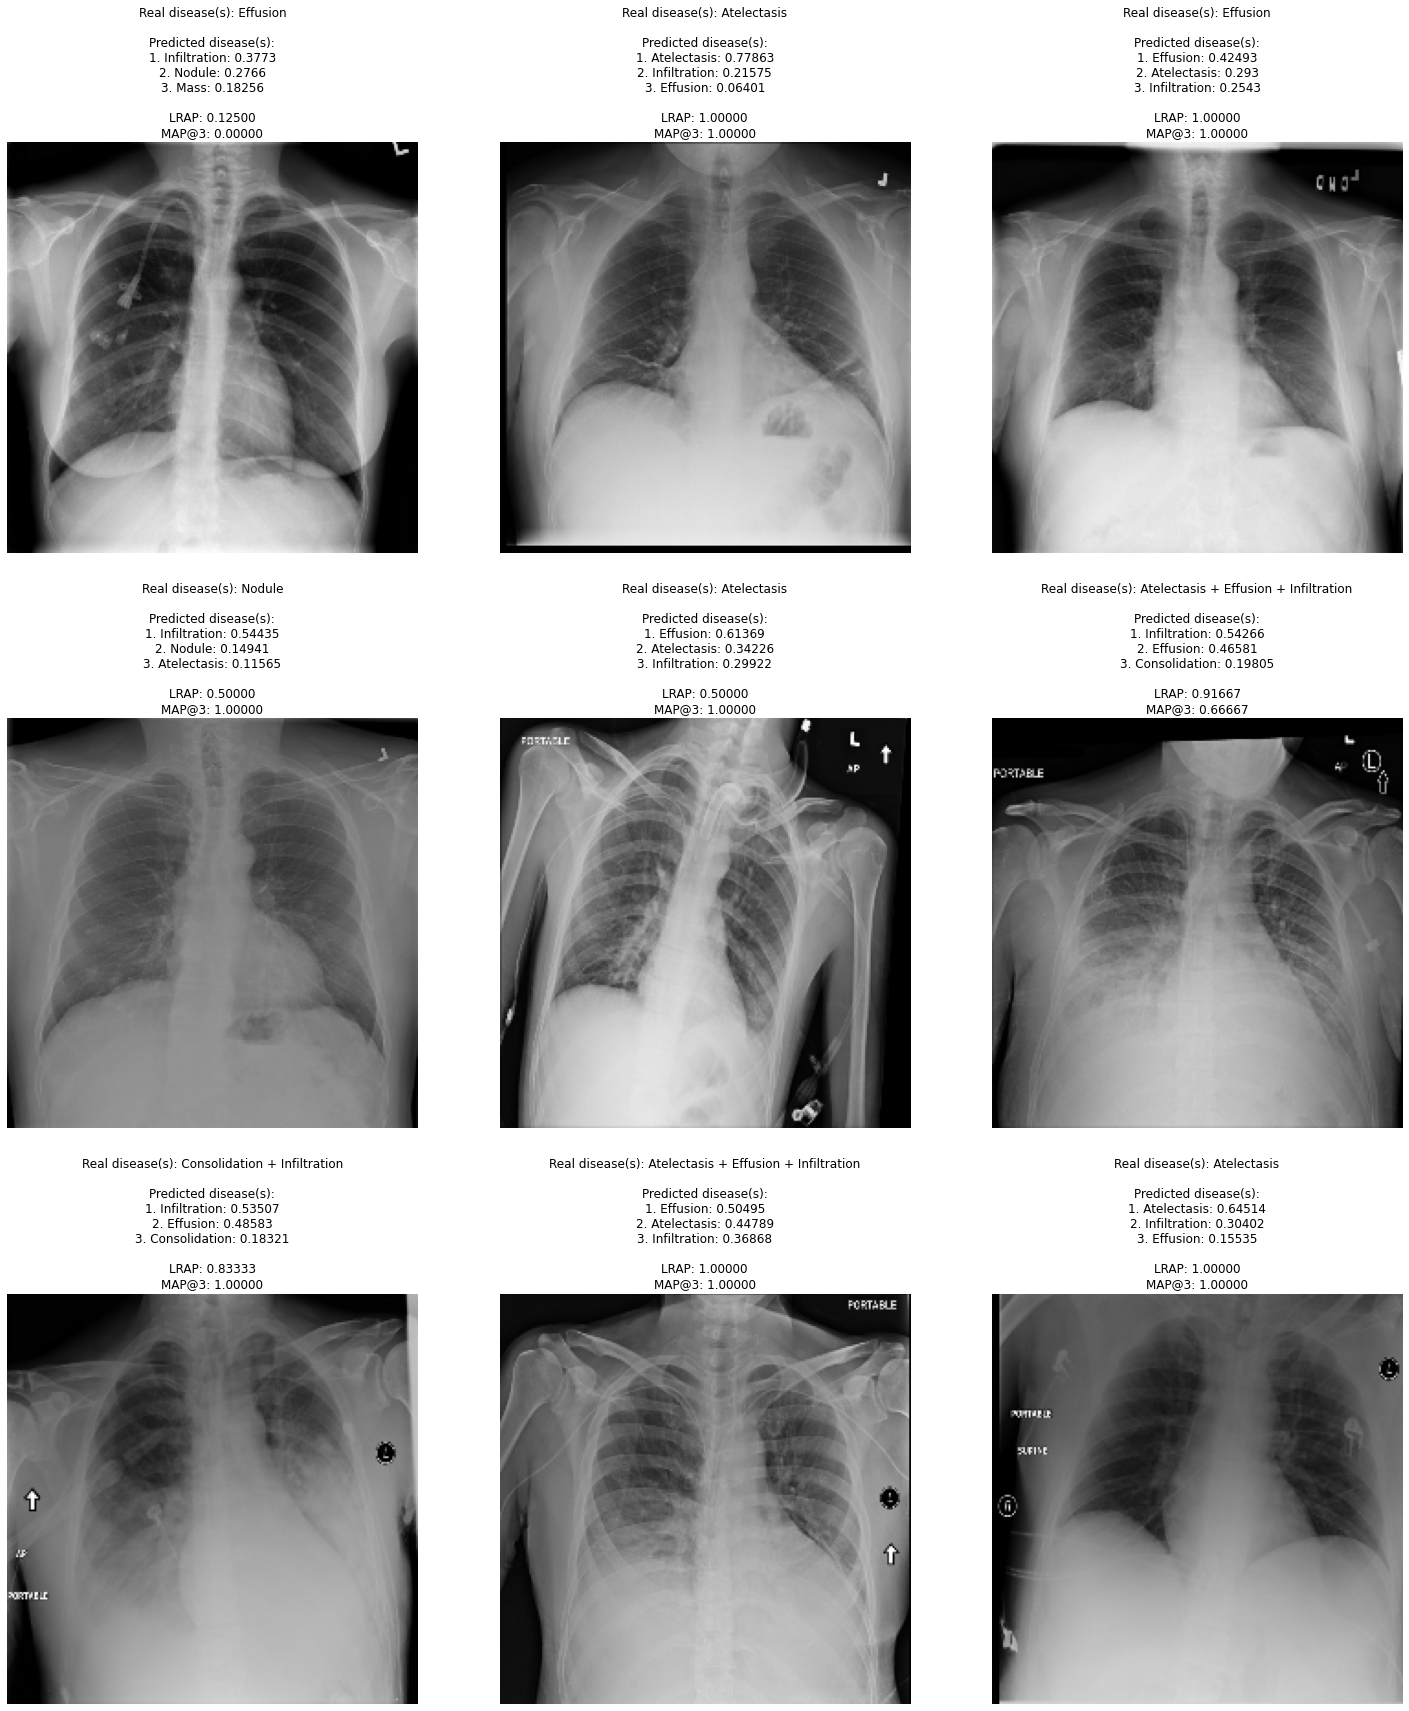

In [41]:
print(k)
simulate_project_output(model, images_sample, class_names_list, k_prob=k, y_real=y_sample, figure_size=(25,30))

## **7.2 Images without disesase**

In [ ]:
images_nofinding_sample, y_nofinding_sample = get_images_labels_from_tfrec(tfrec_folder, mode=2, shuffle=True, seed=123)
print(images_nofinding_sample.shape, y_nofinding_sample.shape)
print(y_nofinding_sample)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
(9, 150, 150, 3) (9, 14)
(9, 150, 150, 3) (9, 14)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 

In [ ]:
y_nofinding_sample[0,4] = 1
print(y_nofinding_sample)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


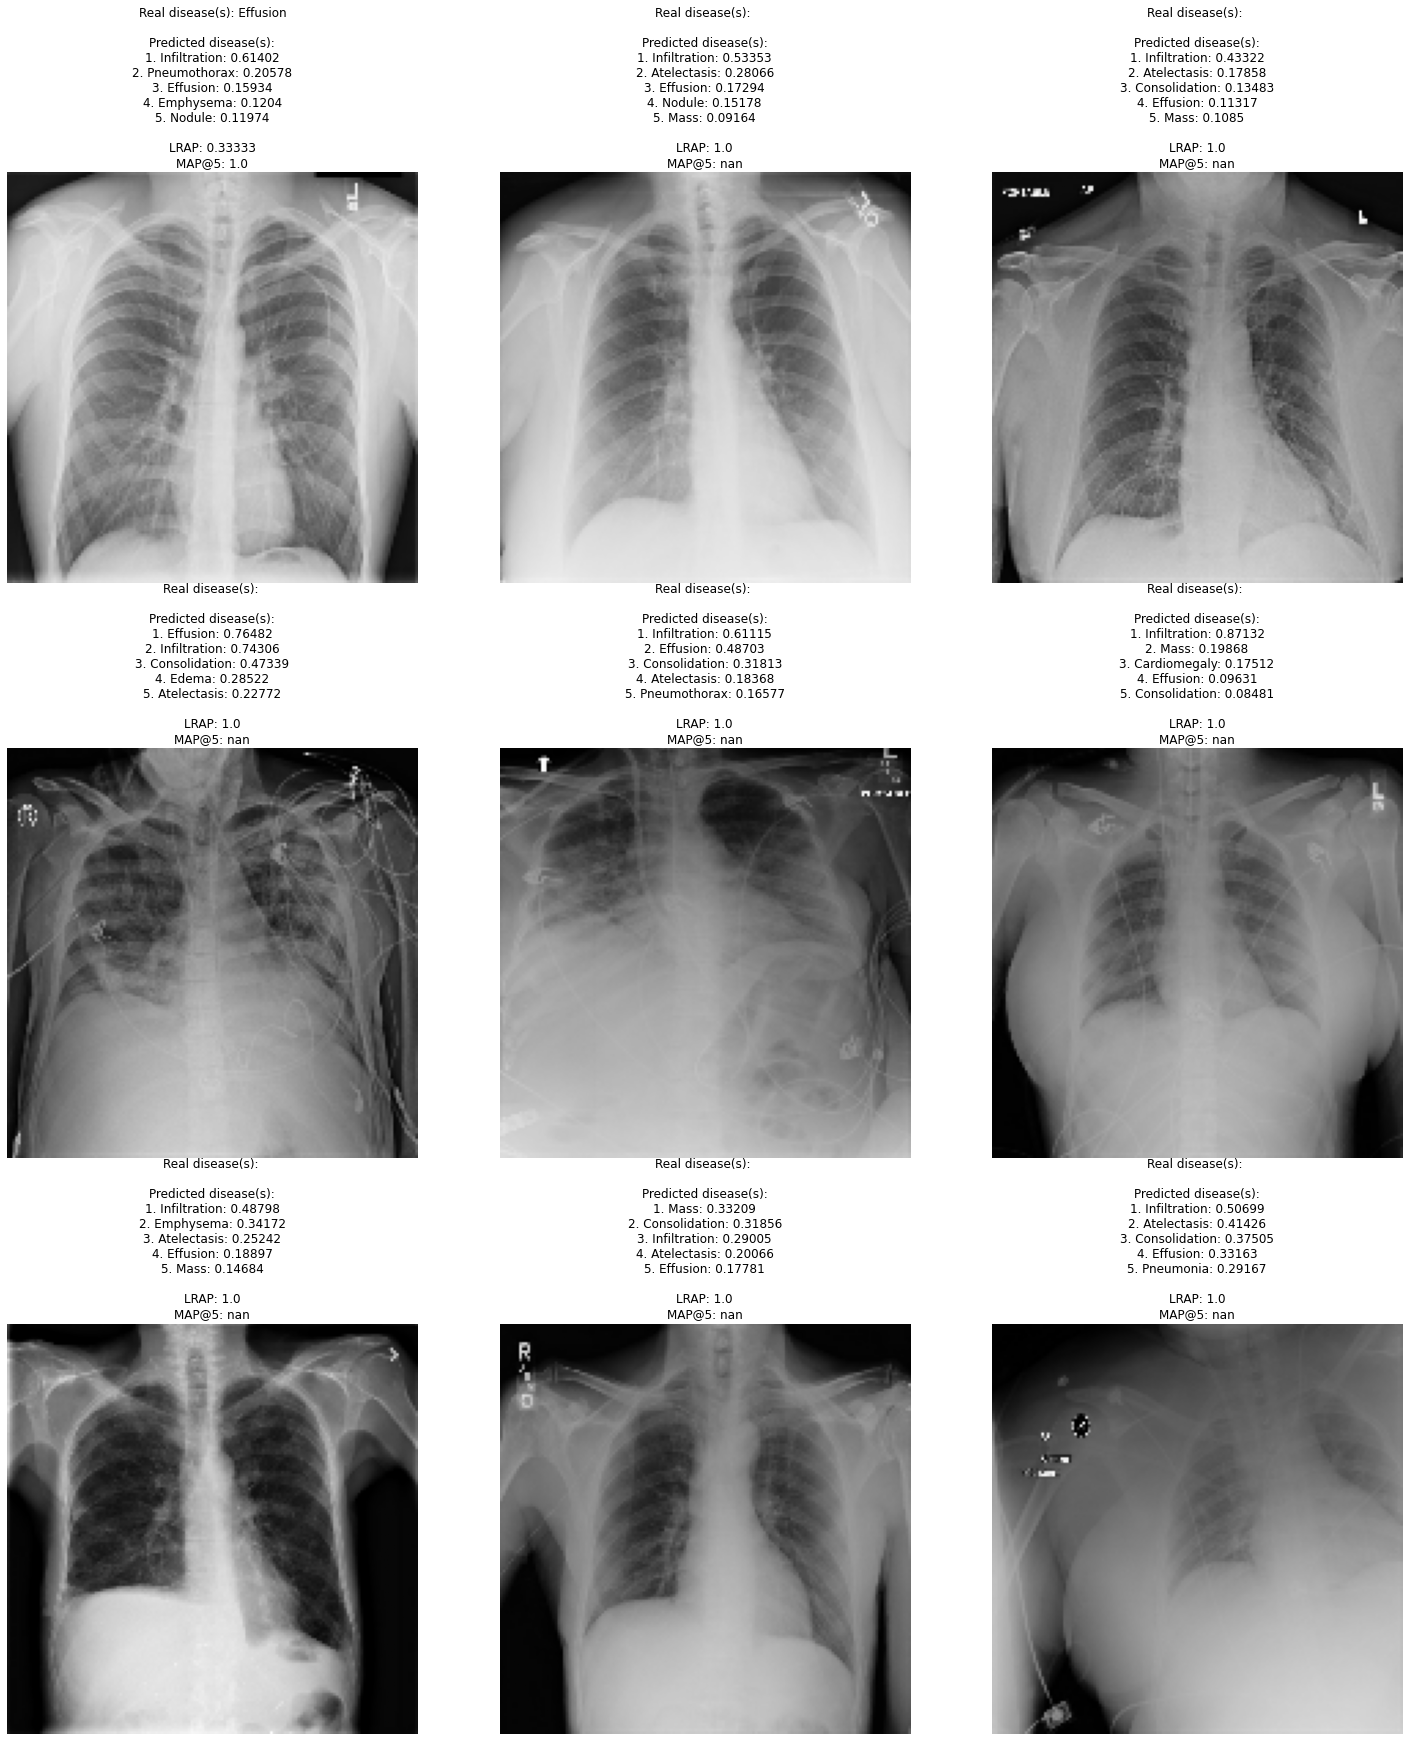

In [ ]:
simulate_project_output(model, images_nofinding_sample, class_names_list, k_prob=5, y_real=y_nofinding_sample, figure_size=(25,30))

In [ ]:
a = tf.data.Dataset.range(4)
a = a.shuffle(3, reshuffle_each_iteration=False)
# a = a.repeat(2)

In [ ]:
list(a.as_numpy_iterator())

[2, 3, 1, 0]